In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_json("http://192.168.1.37:5001/deliveries", convert_dates=["created_at"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   oid         631 non-null    int64              
 1   Company     631 non-null    object             
 2   MyHouse     631 non-null    object             
 3   created_at  631 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 19.8+ KB


In [3]:
df_hh = pd.DataFrame(df[~df["Company"].isin(["UberEats", "DoorDash", "Staples", "Jerome's"])])
df_hh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619 entries, 0 to 630
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   oid         619 non-null    int64              
 1   Company     619 non-null    object             
 2   MyHouse     619 non-null    object             
 3   created_at  619 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 24.2+ KB


In [67]:
delivery_df = df_hh
delivery_df["month"] = delivery_df["created_at"].dt.month
delivery_df["month_name"] = delivery_df["created_at"].dt.month_name()
delivery_df["day"] = delivery_df["created_at"].dt.day_name()
delivery_df["week"] = delivery_df["created_at"].dt.isocalendar().week
delivery_df.tail()

,oid,Company,MyHouse,created_at,month,month_name,day,week
626,669,FedEx,No,2021-03-23 19:59:30+00:00,3,March,Tuesday,12
627,670,Amazon,No,2021-03-24 05:41:00+00:00,3,March,Wednesday,12
628,671,Amazon,No,2021-03-24 18:45:33+00:00,3,March,Wednesday,12
629,672,Amazon,No,2021-03-25 16:46:43+00:00,3,March,Thursday,12
630,673,Amazon,Yes,2021-03-24 09:46:00+00:00,3,March,Wednesday,12


In [5]:
delivery_df.value_counts("month").max()

67

In [6]:
myhouse = delivery_df.value_counts("MyHouse")
pct_myhouse = round(myhouse["Yes"] / myhouse["No"], 2) * 100
print(f"{str(pct_myhouse)}%")

21.0%


<AxesSubplot:title={'center':'Neighborhood Deliveries'}, ylabel='None'>

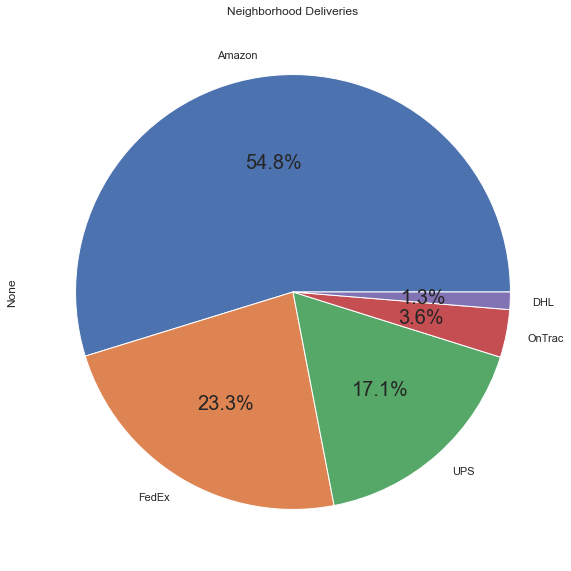

In [7]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.size"] = 20
_plot = df_hh.value_counts("Company").plot.pie(y="Company", x="Count", autopct='%1.1f%%', title="Neighborhood Deliveries")
_plot

(array([339.,   0., 106.,   0.,   0., 144.,   0.,  22.,   0.,   8.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

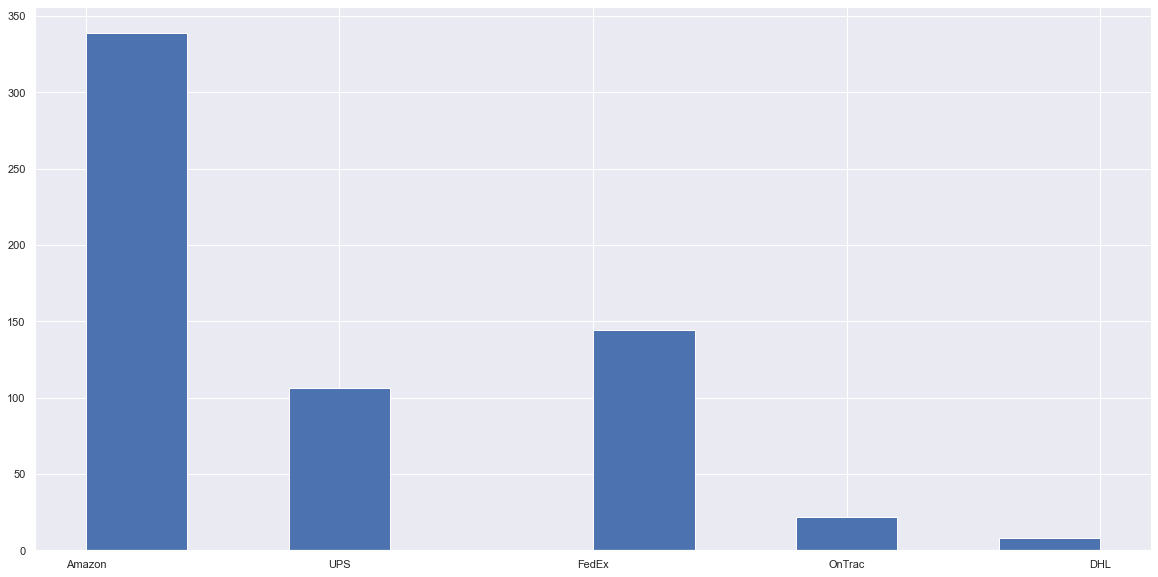

In [8]:
plt.hist(delivery_df["Company"].values)

### How busy is each day?
Weekdays are definitely the busiest but there is still some considerable traffic on the weekends.

<AxesSubplot:xlabel='Day', ylabel='Delivery count'>

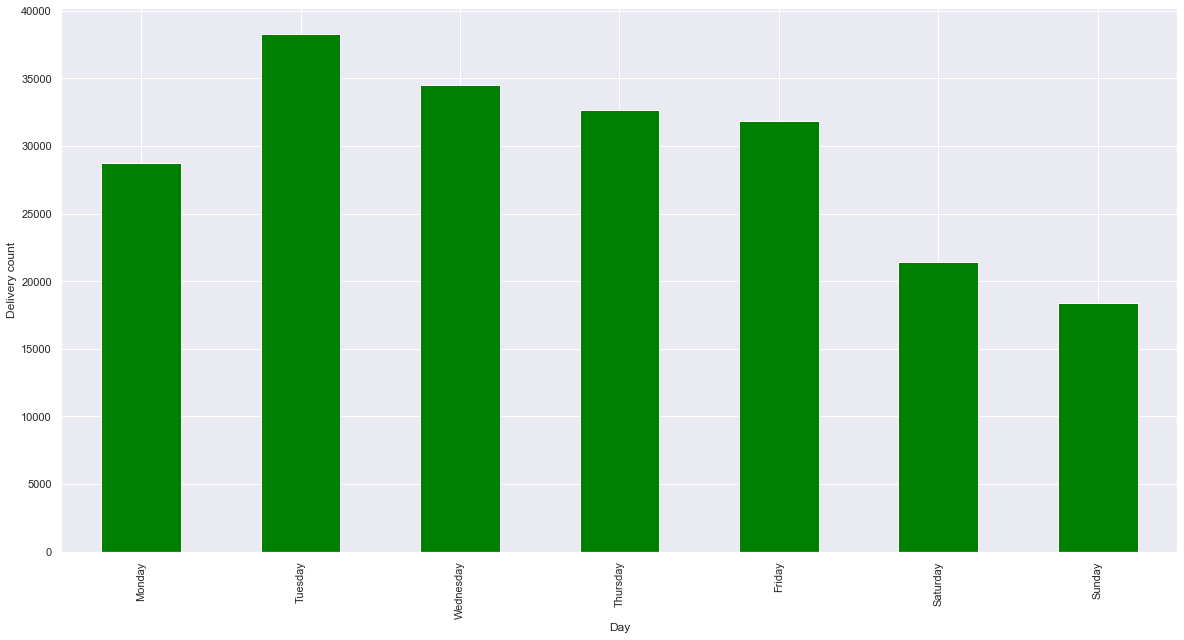

In [68]:
from pandas.api.types import CategoricalDtype
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=days, ordered=True)

day_df = delivery_df.copy()
day_df = day_df.loc[oneyear["created_at"] < "2021-03-24"]
day_df["day"] = day_df['day'].astype(cat_type)
day_df.groupby("day").count()

day_df["Count"] = day_df["oid"]
day_counts = pd.pivot_table(day_df, values=["Count"], columns=["day"], fill_value=0, aggfunc=np.sum)
day_counts.iloc[0].plot(kind="bar", sort_columns=True, xlabel="Day", ylabel="Delivery count", color="green")

### Total Deliveries by Month
Distribution of neighborhood deliveries by month

<AxesSubplot:xlabel='Month'>

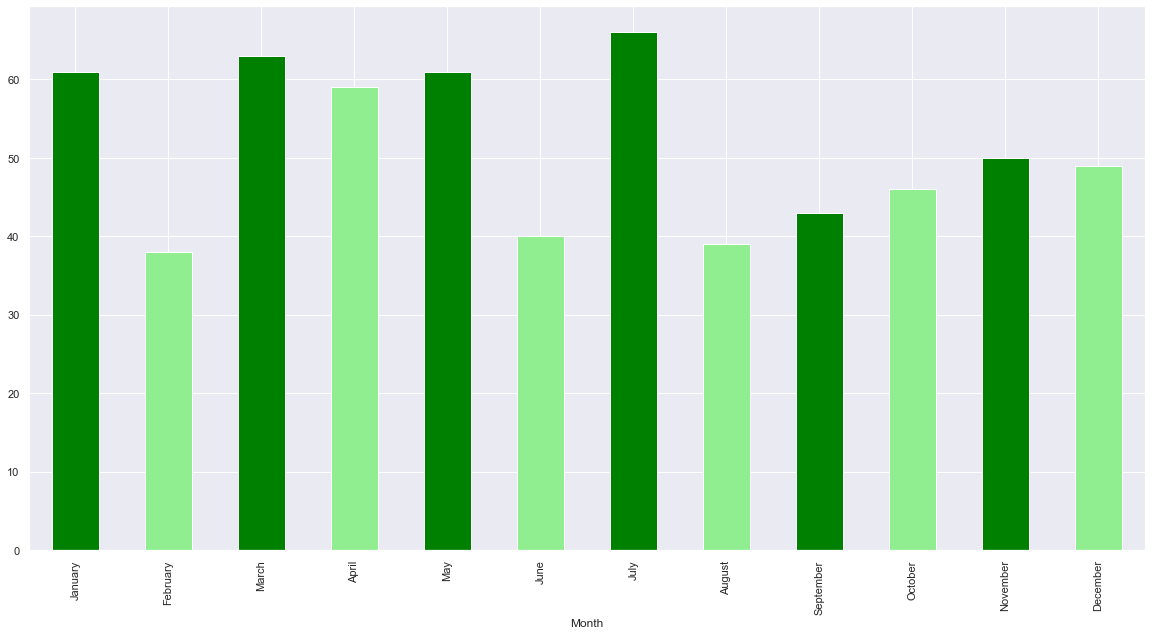

In [159]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
month_df = day_df.groupby("month_name").count()
months_ord = month_df.reindex(months)["Count"]
months_ord.plot.bar(color=["green", "lightgreen"], xlabel="Month")

### Monthly Deliveries by Company
Distribution of the three main delivery companies

In [128]:
def company_month_count(company):
    company_month = delivery_df.loc[df["Company"] == company, ["oid", "month_name", "Company"]].groupby("month_name").count()
    company_month["Count"] = company_month["oid"]
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    return company_month.reindex(months)["Count"]

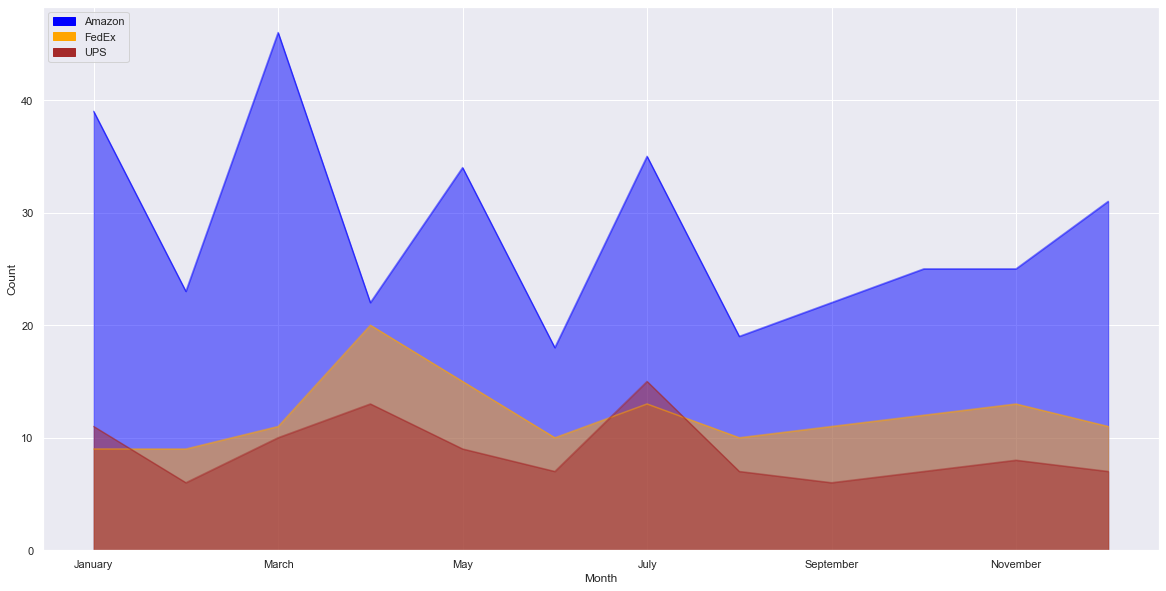

In [157]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
companies = ["Amazon", "FedEx", "UPS"]
colors = ["blue", "orange", "brown"]
AMZN = mpatches.Patch(color='blue', label='Amazon')
FED = mpatches.Patch(color='orange', label='FedEx')
UPS = mpatches.Patch(color='brown', label='UPS')

for i, company in enumerate(companies):
    company_month_count(company).plot(kind="area", xlabel="Month", ylabel="Count", color=colors[i], stacked=False, legend=True)
plt.legend(handles=[AMZN,FED,UPS], loc=2)